In [1]:
test_org='/mnt/Velocity_Vault/Autofocus/Train/'
test_number='train4/'
test_type='scaled_images/'
test_scene='macrohat_8/'
test_frame='7/'
test_position='result_scaled_image_right.jpg'

test_path=test_org+test_number+test_type+test_scene+test_frame+test_position
print(test_path)


#1512 x 2016
#378 x 504

/mnt/Velocity_Vault/Autofocus/Train/train4/scaled_images/macrohat_8/7/result_scaled_image_right.jpg


Slice : 21


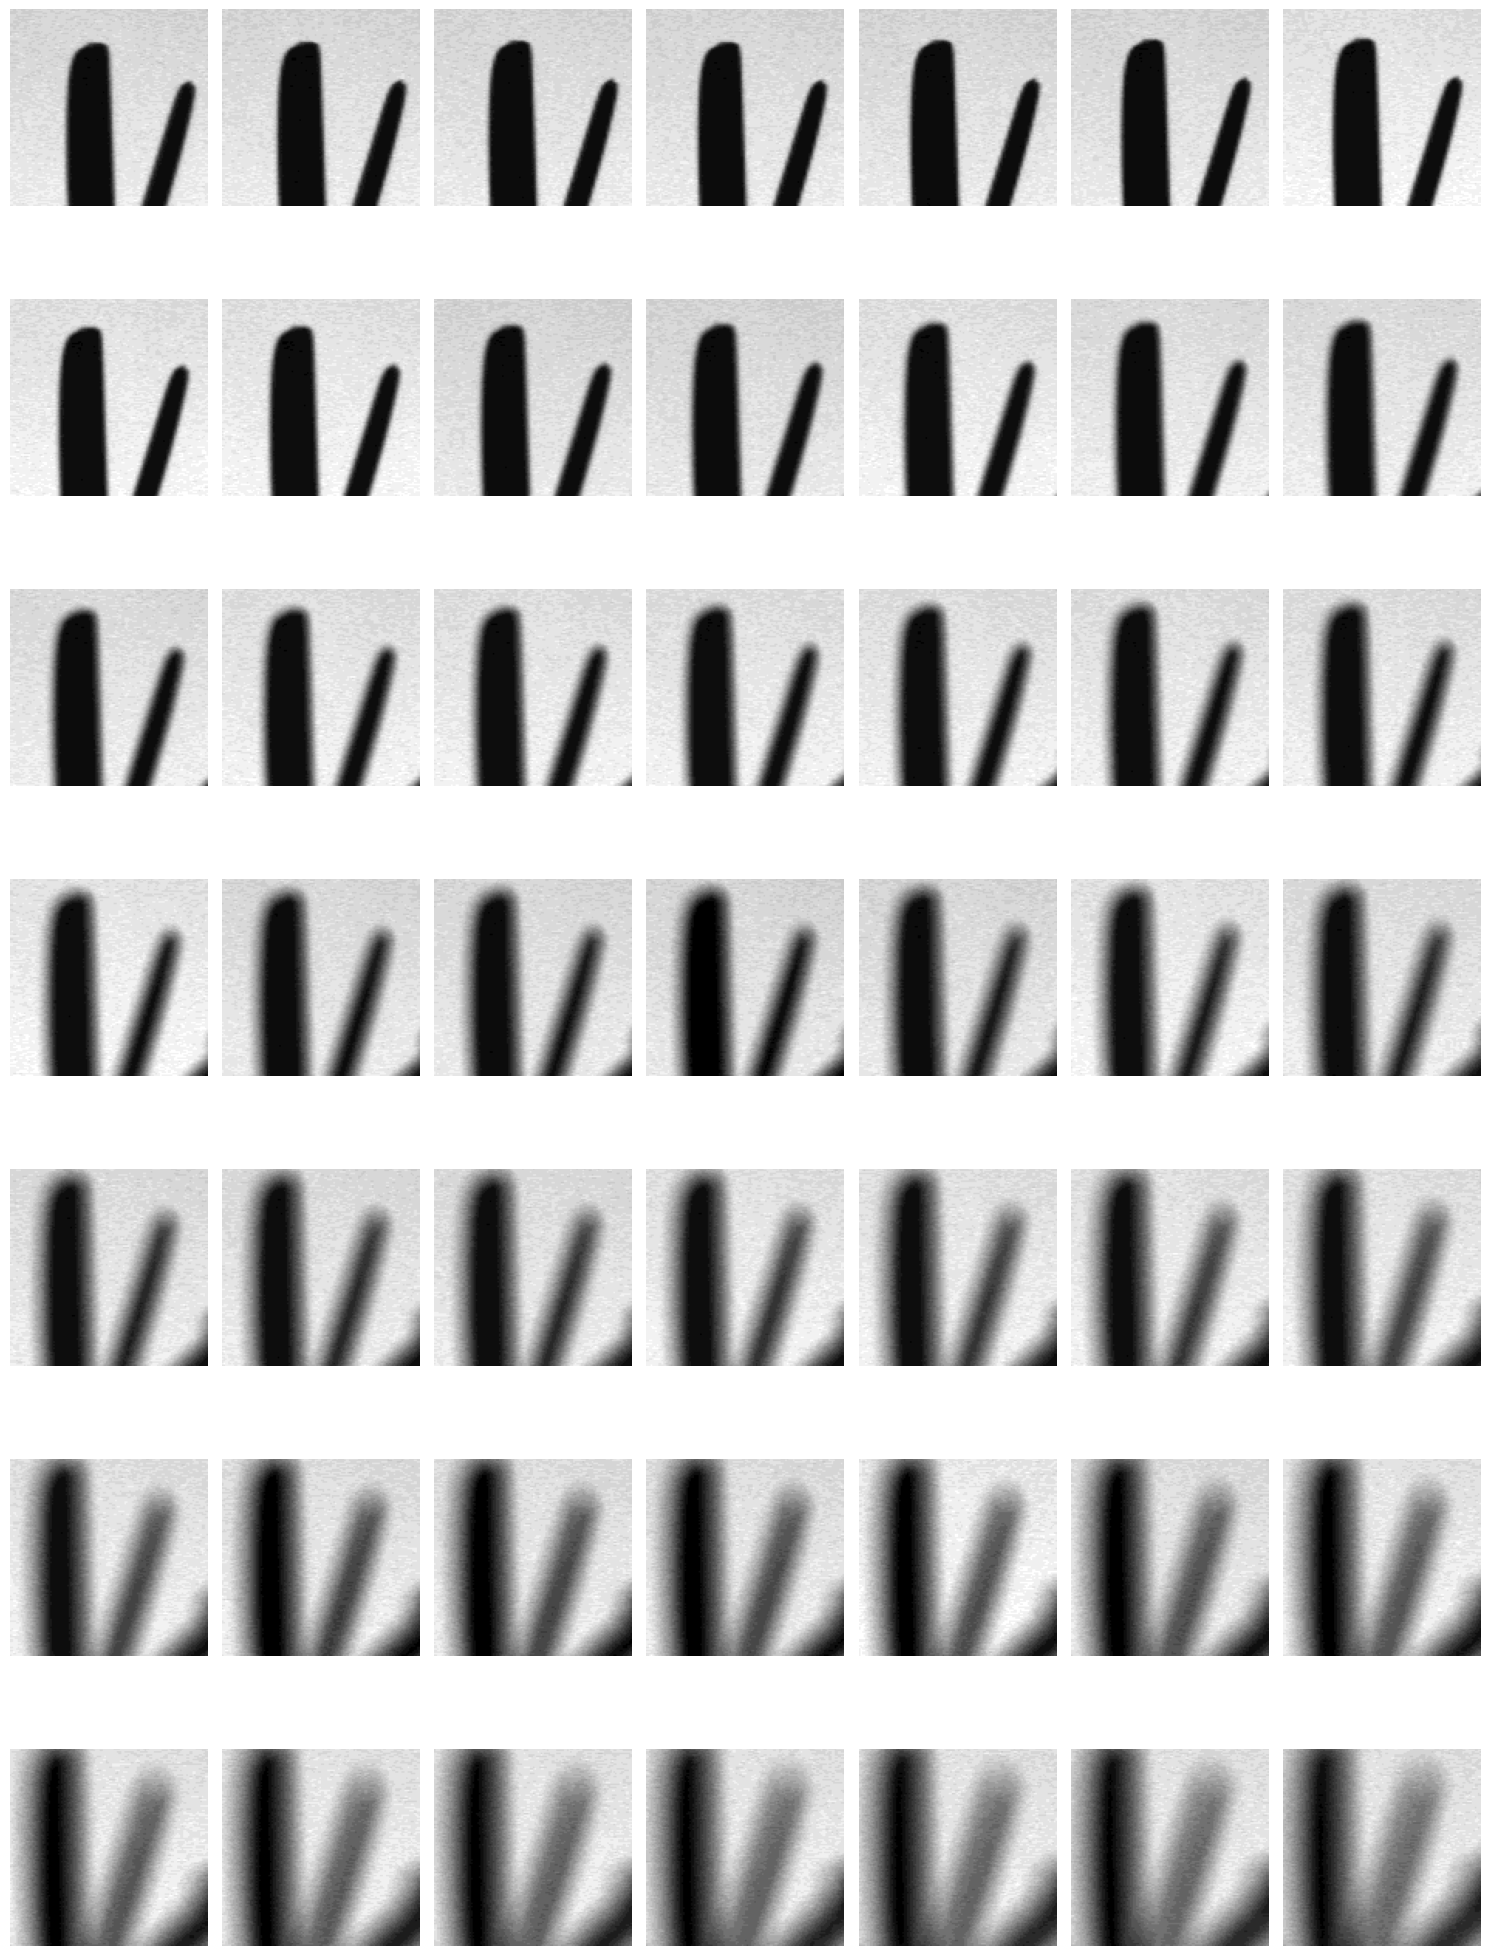

In [10]:

import matplotlib.pyplot as plt
import cv2
import OpenEXR
import Imath
import numpy as np
from pprint import pprint
import random
from tqdm import tqdm

def adjust_brightness(image, brightness_factor):
    # Convert the image to float to prevent overflow issues during addition
    image_float = np.float32(image)
    image_float = image_float * brightness_factor
    image_float = np.clip(image_float, 0, 255)  # Ensure values are within the valid range
    return np.uint8(image_float)

def load_depth_image(image_path,x,y):
    if image_path.lower().endswith('.exr'):
        # Load EXR file
        exr_file = OpenEXR.InputFile(image_path)
        header = exr_file.header()
        dw = header['dataWindow']
        width = dw.max.x - dw.min.x + 1
        height = dw.max.y - dw.min.y + 1

        # Assume depth data is stored in the 'R' channel
        pixel_type = Imath.PixelType(Imath.PixelType.FLOAT)
        channel_data = exr_file.channel('R', pixel_type)

        # Convert buffer to a NumPy array
        depth_array = np.frombuffer(channel_data, dtype=np.float32).reshape((height, width))
    else:
        # Load standard image format (e.g., PNG, JPG)
        depth_array = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if depth_array is None:
            raise ValueError(f"Failed to load image from {image_path}")

        # Convert to float32 for consistency
        depth_array = np.float32(depth_array)

    return depth_array[x:x+64, y:y+64]

def load_exr(exr_path, x,y,channel="R"):

    # Open the EXR file
    exr_file = OpenEXR.InputFile(exr_path)
    
    # Get the file's header information and data window
    header = exr_file.header()
    dw = header['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    
    # Get the channel data
    pixel_type = Imath.PixelType(Imath.PixelType.FLOAT)  # Assuming the data is in float32
    channel_data = exr_file.channel(channel, pixel_type)
    
    # Convert the data to a NumPy array
    np_array = np.frombuffer(channel_data, dtype=np.float32).reshape((height, width))
    
    return np_array[x:x+64, y:y+64]

import numpy as np

def approx_depth(depth, conf):
    # Check if the shapes of depth and conf are the same
    if depth.shape != conf.shape:
        raise ValueError("The depth and conf matrices must have the same shape.")
    
    # Calculate the number of elements in depth
    size = depth.size  # Equivalent to depth.shape[0] * depth.shape[1]

    # Calculate the approx matrix
    approx = (depth * conf)

    # Calculate and return the total sum of approx
    total_sum = np.sum(approx)/size
    return total_sum

def display_map(input_array,bright=False):
    print(input_array.shape)
    print("MAx : ",np.max(input_array))
    # Check if values are within the range [0, 1]
    if np.all((0 <= input_array) & (input_array <= 65535)):
        # Scale the array to the range [0, 256]
        processed_image = ((input_array/65535) * 255).astype(np.uint8)
    else:
        # Keep the array as it is
        processed_image = input_array
        
    if(bright):
        processed_image=adjust_brightness(processed_image,6)
        
        
        
    print("The proc img : \n",processed_image)
    
    int_image=(processed_image/255)*2-1
    print(int_image)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(processed_image, cmap='gray')
    #plt.colorbar()
    plt.title("Full Image")
    plt.axis('off')
    plt.show()
    
    return processed_image

def find_slice(desc_list, number):
    if not desc_list:
        raise ValueError("The list cannot be empty.")
    if not all(desc_list[i] >= desc_list[i + 1] for i in range(len(desc_list) - 1)):
        raise ValueError("The list must be in descending order.")
    
    closest_index = min(range(len(desc_list)), key=lambda i: abs(desc_list[i] - number))
    return closest_index


def display_images_in_grid(image_paths, brighten_flags, x, y, brightness=1.2, marker=None):

    # Calculate the number of rows needed (with at most 7 images per row)
    rows = (len(image_paths) + 6) //7
    fig, axes = plt.subplots(rows, 7, figsize=(15, 3 * rows))
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()
    
    if marker is None:
        marker = []  # Default to an empty list if no markers are provided
    
    for i, image_path in enumerate(image_paths):
        # Try to read the image
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        if img is None:  # Check if image reading failed
            print(f"Error: Could not load image at {image_path}")
            axes[i].axis('off')  # Turn off axis for the failed image
            continue
        
        # Crop the image to the specified (x, y) -> (x+64, y+64)
        img_cropped = img[x:x+128, y:y+128]
        img_cropped=((img_cropped/65535) * 255).astype(np.uint8)
        
        # Convert cropped image from BGR to RGB for correct display
        #img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2RGB)
        
        # If the corresponding flag is True, adjust brightness
        
        # Add a red border if the index is in the marker list
        if i in marker:
            img_cropped = cv2.copyMakeBorder(img_cropped, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=[255, 0, 0])
        
        # Display the image
        axes[i].imshow(img_cropped,cmap='gray')
        axes[i].axis('off')  # Turn off axis for each image
    
    # Turn off axes for any unused subplots
    for i in range(len(image_paths), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

dp_left=test_org+test_number+"raw_up_left_pd/"+test_scene+test_frame+"result_up_pd_left_center.png"
dp_right=test_org+test_number+"raw_up_right_pd/"+test_scene+test_frame+"result_up_pd_right_center.png"
depth=test_org+test_number+"merged_depth/"+test_scene+"result_merged_depth_center.png"
conf=test_org+test_number+"merged_conf/"+test_scene+"result_merged_conf_center.exr"

display=[test_path,dp_left,dp_right,depth]


# display_bright[-2]=True
# display_bright[-3]=True
#display_images_in_grid(display,display_bright,50,50)

conf_matrix=load_exr(conf,50,50)
depth_matrix=load_depth_image(depth,50,50)
approx=approx_depth(depth_matrix,conf_matrix)

# pprint(conf_matrix)
# pprint(depth_matrix)
# print(approx)

approx=approx/255.0

max_val=4
min_val=0.1

# max_val=100
# min_val=0.2

metre=(max_val * min_val) / (max_val - (max_val - min_val) * approx)
metre*=1000

slice_focal_length=[3910.92,2289.27,1508.71,1185.83,935.91,801.09,700.37,605.39,546.23,486.87,447.99,407.40,379.91,350.41,329.95,307.54,291.72,274.13,261.53,247.35,237.08,225.41,216.88,207.10,198.18,191.60,183.96,178.29,171.69,165.57,160.99,155.61,150.59,146.81,142.35,138.98,134.99,131.23,127.69,124.99,121.77,118.73,116.40,113.63,110.99,108.47,106.54,104.23,102.01]

slice_focus=find_slice(slice_focal_length,metre)
print("Slice :",slice_focus)



display=[]
for i in range(49):
    frame=str(i)+"/"
    display.append(test_org+test_number+test_type+test_scene+frame+test_position)

display_bright=[False for _ in range(len(display))]

#display_images_in_grid(display,display_bright,50,50,marker=[slice_focus])


def get_image_array(image_path,x,y,change_range=False):
    
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED) 
    
    
    send=image[x:x+128,y:y+128]
    #print(type(image[0][0]))
    if change_range:
        send=convert_range(send)
        
    #print(image.shape)
    
    return send


leftt='/mnt/Velocity_Vault/Autofocus/Test/raw_up_left_pd/secondfloorgames_0/5/result_up_pd_left_center.png'
dd='/mnt/Velocity_Vault/Autofocus/Train/train1/merged_depth/apt1_0/result_merged_depth_center.png'
sc='/mnt/Velocity_Vault/Autofocus/Train/train1/scaled_images/apt1_0/0/result_scaled_image_center.jpg'
xx=301
yy=200

tester=[[6212 for _ in range(128)] for _ in range(128)]
im_arr=get_image_array(leftt,xx,yy)

# display_map(im_arr)
# display_map(np.array(tester))


image_all=[]
for i in range(49):
    leftt='/mnt/Velocity_Vault/Autofocus/Test/raw_up_left_pd/secondfloorgames_0/'+str(i)+'/result_up_pd_left_center.png'
    #im_arr=get_image_array(leftt,xx,yy)
    xx=301
    yy=200
    image_all.append(leftt)
    
display_bright=[False for _ in range(len(image_all))]
    
display_images_in_grid(image_all,display_bright,xx,yy,marker=[])

    
    
# display_map(get_image_array(dd,xx//4,yy//4,small=True),bright=False)
# display_map(get_image_array(sc,xx//4,yy//4,small=True),bright=False)

# display_map(depth_matrix)
# display_map(conf_matrix)

In [8]:
import random
def generate_positions(size, clear, countx,county):
    positions=[]
    pad=clear//2
    for i in range(countx):
        for j in range(county):
            positions.append([i*(size+clear)+pad,j*(size+clear)+pad])
    return positions

print(generate_positions(128,40,12,9))

def create_patches(n):
    
    def generate_positions(size, clear, countx,county):
        positions=[]
        pad=clear//2
        for i in range(countx):
            for j in range(county):
                positions.append([i*(size+clear)+pad,j*(size+clear)+pad])
        return positions
    
    positions=generate_positions(128,40,12,9)
    
    if n > len(positions):
        raise ValueError("n cannot be greater than the length of the list.")
    
    return random.sample(positions, n)

print(create_patches(9))

[[20, 20], [20, 188], [20, 356], [20, 524], [20, 692], [20, 860], [20, 1028], [20, 1196], [20, 1364], [188, 20], [188, 188], [188, 356], [188, 524], [188, 692], [188, 860], [188, 1028], [188, 1196], [188, 1364], [356, 20], [356, 188], [356, 356], [356, 524], [356, 692], [356, 860], [356, 1028], [356, 1196], [356, 1364], [524, 20], [524, 188], [524, 356], [524, 524], [524, 692], [524, 860], [524, 1028], [524, 1196], [524, 1364], [692, 20], [692, 188], [692, 356], [692, 524], [692, 692], [692, 860], [692, 1028], [692, 1196], [692, 1364], [860, 20], [860, 188], [860, 356], [860, 524], [860, 692], [860, 860], [860, 1028], [860, 1196], [860, 1364], [1028, 20], [1028, 188], [1028, 356], [1028, 524], [1028, 692], [1028, 860], [1028, 1028], [1028, 1196], [1028, 1364], [1196, 20], [1196, 188], [1196, 356], [1196, 524], [1196, 692], [1196, 860], [1196, 1028], [1196, 1196], [1196, 1364], [1364, 20], [1364, 188], [1364, 356], [1364, 524], [1364, 692], [1364, 860], [1364, 1028], [1364, 1196], [1364

In [9]:

# given one image location for raw left, raw right, merged depth, merged_conf

import random
from tqdm import tqdm
import time
import os

test_scene='apt1_3'

left_loc=[test_org+test_number+"raw_up_left_pd/"+test_scene]
right_loc=[test_org+test_number+"raw_up_right_pd/"+test_scene]
depth_loc=[test_org+test_number+"merged_depth/"+test_scene]
conf_loc=[test_org+test_number+"merged_conf/"+test_scene]

# left_loc.append(left_loc[0])
# right_loc.append(right_loc[0])
# depth_loc.append(depth_loc[0])
# conf_loc.append(conf_loc[0])

train_set=[left_loc,right_loc,depth_loc,conf_loc]

memmap_path='/mnt/Personal/Projects/Python/Autofocus/MemMap/'

image_patch = np.memmap(memmap_path+"image_patch.dataset", dtype=np.float64, mode='w+', shape=(9*len(train_set[0]),128, 128,98))
ground_truth = np.memmap(memmap_path+"ground_truth.dataset", dtype=int, mode='w+', shape=(9*len(train_set[0])))

#image_patch=np.empty((9*len(train_set[0]),128, 128,98))
#ground_truth=np.empty(9*len(train_set[0]),dtype=int)


def check_image_connection(image_path):
    # Display the "Reconnect Drive" message
    
    print("Reconnect Drive")
    checking=True
    
    while checking:
        # Try reading the image
        if (not os.path.isfile(image_path)) or (not os.path.isdir('/mnt/Velocity_Vault')):
            time.sleep(10)
        else:
            print(image_path)
            checking=False
    print("Drive Connected")

def convert_range(value, old_min=0, old_max=65535, new_min=-1, new_max=1):
    # Linear interpolation formula
    return ((value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min


def get_image_array(image_path,x,y,change_range=False):
    
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED) 
    
    if image is None:
        check_image_connection(image_path)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    send=image[x:x+128,y:y+128]
    
    if change_range:
        send=convert_range(send)
        
    #print(image.shape)
    
    return send


def load_depth_image(image_path,x,y):
    # Load standard image format (e.g., PNG, JPG)
    depth_array = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    if depth_array is None:
        check_image_connection(image_path)
        depth_array = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Convert to float32 for consistency
    depth_array = np.float32(depth_array)

    return depth_array[x:x+32, y:y+32]

def load_conf_image(exr_path, x,y,channel="R"):
    
    try:
        exr_file = OpenEXR.InputFile(exr_path)
    except Exception as e:
        check_image_connection(exr_path)
        exr_file = OpenEXR.InputFile(exr_path)
        
    header = exr_file.header()
    dw = header['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    pixel_type = Imath.PixelType(Imath.PixelType.FLOAT)  
    channel_data = exr_file.channel(channel, pixel_type)
    np_array = np.frombuffer(channel_data, dtype=np.float32).reshape((height, width))
    
    return np_array[x:x+32, y:y+32]


def approx_depth(depth, conf):
    
    depth_values = depth.flatten()
    confidence_values = conf.flatten()

    # Compute the weighted average depth
    weighted_sum = np.sum(depth_values * confidence_values)
    total_confidence = np.sum(confidence_values)
    
    approximate_depth = weighted_sum / total_confidence

    return approximate_depth


def find_slice(desc_list, number):
    if not desc_list:
        raise ValueError("The list cannot be empty.")
    if not all(desc_list[i] >= desc_list[i + 1] for i in range(len(desc_list) - 1)):
        raise ValueError("The list must be in descending order.")
    
    closest_index = min(range(len(desc_list)), key=lambda i: abs(desc_list[i] - number))
    return closest_index


def predict_slice(depth):
    
    approx=depth/255.0

    max_val=100
    min_val=0.2

    metre=(max_val * min_val) / (max_val - (max_val - min_val) * approx)
    metre*=1000

    slice_focal_length=[3910.92,2289.27,1508.71,1185.83,935.91,801.09,700.37,605.39,546.23,486.87,447.99,407.40,379.91,350.41,329.95,307.54,291.72,274.13,261.53,247.35,237.08,225.41,216.88,207.10,198.18,191.60,183.96,178.29,171.69,165.57,160.99,155.61,150.59,146.81,142.35,138.98,134.99,131.23,127.69,124.99,121.77,118.73,116.40,113.63,110.99,108.47,106.54,104.23,102.01]

    slice_focus=find_slice(slice_focal_length,metre)
    
    return slice_focus
    
def create_patches(n):
    
    def generate_positions(size, clear, countx,county):
        positions=[]
        pad=clear//2
        for i in range(countx):
            for j in range(county):
                positions.append([i*(size+clear)+pad,j*(size+clear)+pad])
        return positions
    
    positions=generate_positions(128,40,12,9)
    
    if n > len(positions):
        raise ValueError("n cannot be greater than the length of the list.")
    
    return random.sample(positions, n)

def transpose_list(input_list):
    np_array = np.array(input_list)
    transposed_array = np.transpose(np_array, (1, 2, 0))
    return transposed_array

def make_stack(left_loc,right_loc,depth_loc,conf_loc):
    
    slices=np.zeros((9,128, 128,98))
    truth=[0 for _ in range(9)]
    
    patch_pos=create_patches(9)
    
    for pos,patch in enumerate(patch_pos):
        
        x=patch[0]
        y=patch[1]
        
        frames=np.zeros((98, 128, 128))
        
        for i in range(49):
            left_frame=left_loc+"/"+str(i)+'/result_up_pd_left_center.png'
            right_frame=right_loc+"/"+str(i)+'/result_up_pd_right_center.png'
            
            #print(x," ",y)
            #print(get_image_array(left_frame,x,y))

            frames[i*2]=get_image_array(left_frame,x,y,change_range=True)
            frames[i*2+1]=get_image_array(right_frame,x,y,change_range=True)
            
        # display_map(frames[0])
            
        slices[pos]=transpose_list(frames)
            
        depth_frame=depth_loc+'/result_merged_depth_center.png'
        conf_frame=conf_loc+'/result_merged_conf_center.exr'
        
        x//=4
        y//=4
        
        depth=load_depth_image(depth_frame,x,y)
        conf=load_conf_image(conf_frame,x,y)
        
        print(depth)
        
        
                
        # display_map(depth)
        # display_map(conf)
        
        approx=approx_depth(depth,conf)
        focus=predict_slice(approx)
        
        print(approx)
        
        truth[pos]=focus
        
        
    return slices,truth

for i in tqdm(range(len(train_set[0]))):
    
    left_loc=train_set[0][i]
    right_loc=train_set[1][i]
    depth_loc=train_set[2][i]
    conf_loc=train_set[3][i]
    
    slices,truth=make_stack(left_loc,right_loc,depth_loc,conf_loc)
    
    for j in range(9):
        image_patch[9*i+j]=slices[j]
        ground_truth[9*i+j]=truth[j]

print(ground_truth.shape)
print(image_patch.shape)
pprint(ground_truth)
pprint(image_patch)
    

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import cv2

def get_img(image_path,change_range=False):
    
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise ValueError(f"Error: Could not load image from {image_path}")
    
    
    if change_range:
        image=convert_range(image,old_min=0, old_max=255, new_min=0, new_max=65535)
        
    #print(image.shape)
    
    return image

def read_16bit_png(image_path):
    # Read the image with flag -1 to retain original bit depth (including 16-bit)
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    if image is None:
        raise ValueError(f"Error: Could not load image from {image_path}")
    
    image=image[0:224,0:224]
    image=convert_range(image,old_min=0, old_max=65535, new_min=0, new_max=225)
    im=np.zeros((224, 224, 3))
    
    for i in range(224):
        for j in range(224):
            im[i][j]=[image[i,j],image[i,j],image[i,j]]
            
    return im

# Example usage
image_path = "/mnt/Personal/Projects/Python/Autofocus/test2.png"
img = read_16bit_png(image_path)
img2=get_img(image_path,change_range=True)
from pprint import pprint
pprint(img.shape)


from keras.applications.mobilenet_v2 import preprocess_input
data = np.empty((1, 224, 224, 3))
data[0]=img
data = preprocess_input(data)

# pprint(data)
# pprint(data.shape)
# pprint(data.dtype)
# pprint(img)
# pprint(img2)
#pprint(np.max(img))#16368


(224, 224, 3)


2025-01-14 01:17:44.311268: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 01:17:44.320070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-14 01:17:44.332808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-14 01:17:44.332855: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 01:17:44.342246: I tensorflow/core/platform/cpu_feature_gua

In [5]:
import numpy as np

def get_max_positions(array):
    # Find the index of the max value along each row
    return np.argmax(array, axis=1)

# Example usage
array = np.random.rand(5, 49)  # Example array of shape (5, 49)
max_positions = get_max_positions(array)

print("Array:\n", array)
print("Max positions:", max_positions)
print(max_positions.shape)


Array:
 [[0.11548828 0.49538057 0.23068149 0.89919144 0.00556323 0.99083809
  0.95629978 0.89120494 0.92775412 0.13582004 0.08308662 0.04531804
  0.28700364 0.28592132 0.2232554  0.24350667 0.29004202 0.80130011
  0.29535586 0.33032976 0.81190973 0.85354331 0.93811981 0.75121176
  0.06424391 0.16641266 0.04498566 0.71117511 0.23928301 0.00882743
  0.42538456 0.57043057 0.21626657 0.63443457 0.53126146 0.44333131
  0.45445152 0.66624559 0.91954656 0.05777664 0.87036245 0.68268313
  0.39847797 0.2820612  0.94584145 0.98799969 0.45635305 0.97572758
  0.39736625]
 [0.41538513 0.27648706 0.04773981 0.20860126 0.24188902 0.83923656
  0.13087641 0.02947759 0.86676356 0.2099762  0.42522399 0.92107856
  0.85484214 0.08325288 0.95166734 0.14945835 0.47346627 0.96146498
  0.63244764 0.32319596 0.72641043 0.38833594 0.22613482 0.33635543
  0.19483019 0.40656402 0.51615856 0.35804537 0.9274905  0.31735065
  0.05969302 0.41261032 0.27549185 0.34332694 0.01060684 0.88653732
  0.42028443 0.75118855 0.

In [7]:
import numpy as np

def calculate_accuracy(array1, array2):
    # Check if both arrays are the same shape
    if array1.shape != array2.shape:
        raise ValueError("Arrays must have the same shape")
    
    # Compare the arrays and calculate the accuracy
    correct_predictions = np.sum(array1 == array2)
    total_elements = array1.size
    
    accuracy = correct_predictions / total_elements
    return accuracy*100

# Example usage
array1 = np.array([[8, 4, 0, 4, 2], [0, 8, 3, 2, 2], [4, 8, 3, 1, 5]])
array2 = np.array([[8, 4, 0, 4, 2], [0, 8, 3, 2, 2], [4, 7, 3, 1, 5]])

accuracy = calculate_accuracy(array1, array2)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 93.3333


In [1]:
def calculate_mse(predictions, ground_truth):
    """
    Calculate Mean Squared Error (MSE) for ordinal regression predictions.

    Args:
        predictions (list or np.ndarray): Predicted class labels.
        ground_truth (list or np.ndarray): True class labels.

    Returns:
        float: Mean Squared Error.
    """
    assert len(predictions) == len(ground_truth), "Prediction and ground truth lists must have the same length."
    
    # Compute squared errors
    squared_errors = [(p - gt) ** 2 for p, gt in zip(predictions, ground_truth)]
    
    # Calculate mean of squared errors
    mse = sum(squared_errors) / len(ground_truth)
    
    return mse

predictions = [3, 1, 4, 0, 2]
ground_truth = [3, 1, 4, 0, 1]

mse = calculate_mse(predictions, ground_truth)
print(f"Mean Squared Error: {mse:.2f}")


Mean Squared Error: 0.20


In [ ]:
import tensorflow as tf
import subprocess

class GPUUsageCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Use nvidia-smi to get GPU usage details
        try:
            result = subprocess.run(
                ['nvidia-smi', '--query-gpu=memory.used,memory.total,utilization.gpu', '--format=csv,noheader,nounits'],
                stdout=subprocess.PIPE,
                text=True
            )
            gpu_info = result.stdout.strip().split("\n")
            for idx, info in enumerate(gpu_info):
                memory_used, memory_total, utilization = map(int, info.split(", "))
                print(f"Epoch {epoch + 1}: GPU {idx}: {memory_used} MiB/{memory_total} MiB, Utilization: {utilization}%")
        except FileNotFoundError:
            print("nvidia-smi command not found. Please ensure NVIDIA drivers are installed and nvidia-smi is available.")
        except Exception as e:
            print(f"Error fetching GPU usage: {e}")

# Example Model Training
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Example dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Use the GPUUsageCallback
model.fit(
    x_train, y_train,
    epochs=5,
    callbacks=[GPUUsageCallback()]
)


2025-01-16 00:58:30.568649: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 00:58:30.579313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736969310.591417  435364 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736969310.594713  435364 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 00:58:30.606784: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 7s 1us/step


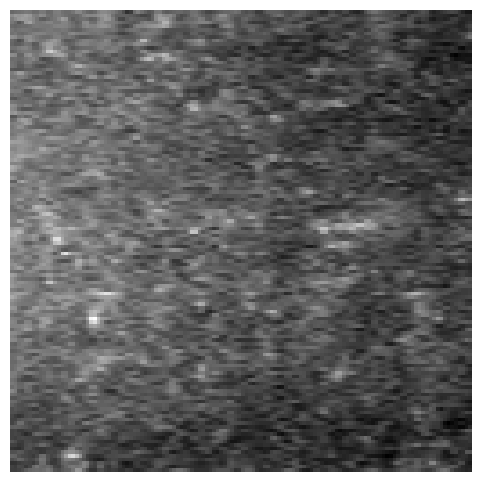

array([[1748, 1764, 1772, ..., 1528, 1480, 1480],
       [1864, 1900, 1892, ..., 1584, 1552, 1548],
       [1816, 1860, 1900, ..., 1536, 1536, 1548],
       ...,
       [1572, 1580, 1604, ..., 1636, 1516, 1484],
       [1620, 1604, 1644, ..., 1540, 1516, 1516],
       [1612, 1608, 1624, ..., 1544, 1528, 1536]], dtype=uint16)


In [ ]:
import cv2
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
def get_image_array(image_path,x,y,change_range=False):
    
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED) 
    
    if image is None:
        check_image_connection(image_path)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    send=image[x:x+128,y:y+128]
    
    if change_range:
        send=convert_range(send)
        
        
    plt.figure(figsize=(6, 6))
    plt.imshow(send, cmap='gray')
    #plt.colorbar()
    plt.axis('off')
    plt.show()
        
    #print(image.shape)
    
    return send

x=get_image_array('/mnt/Velocity_Vault/Autofocus/Test/raw_up_right_pd/home1_0/0/result_up_pd_right_center.png',50,50)
pprint(x)

4260
170.4


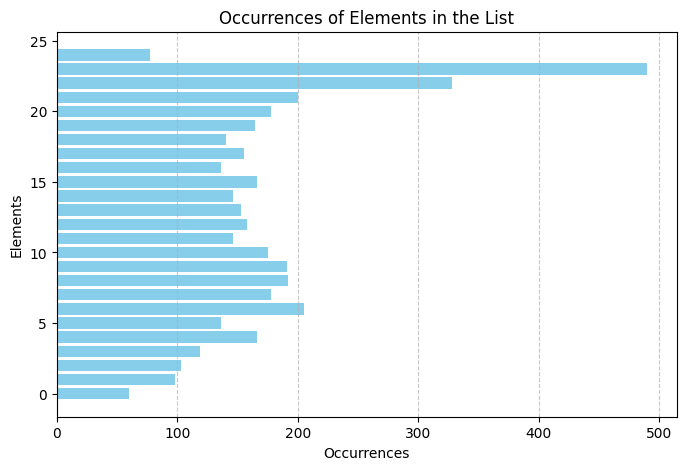

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def plot_occurrences(numbers):
    """
    Plots a horizontal bar graph of the occurrences of elements in a list.

    Parameters:
        numbers (list): A list of numbers to analyze.
    """
    # Count occurrences of each element
    occurrences = Counter(numbers)
    

    # Extract keys (unique numbers) and their corresponding values (counts)
    elements = list(occurrences.keys())
    counts = list(occurrences.values())
    print(np.mean(counts))

    # Plot a horizontal bar graph
    plt.figure(figsize=(8, 5))
    plt.barh(elements, counts, color="skyblue")
    plt.xlabel("Occurrences")
    plt.ylabel("Elements")
    plt.title("Occurrences of Elements in the List")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()


memmap_path='/mnt/Velocity_Vault/Autofocus/Dataset_Storage/'
num_patches=12
train_truth = np.memmap(memmap_path+"ordered_train_truth", dtype=int, mode='r', shape=(num_patches*355))
print(len(train_truth))
# Example usage
plot_occurrences(train_truth)



In [21]:
import numpy as np

def sort_by_truth(dataset, truth):
    sorted_indices = np.argsort(truth)
    dataset = dataset[sorted_indices]
    truth = truth[sorted_indices]
    return dataset, truth

# Example usage
dataset = np.array([[1, 2], [3, 4], [5, 6]])
truth = np.array([2, 0, 1])

sorted_dataset, sorted_truth = sort_by_truth(dataset, truth)
sorted_dataset, sorted_truth


(array([[3, 4],
        [5, 6],
        [1, 2]]),
 array([0, 1, 2]))